In [3]:

import json
import pathlib
import urllib.parse

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
from shapely.geometry import shape

import sqlalchemy as db
import sqlalchemy.dialects.postgresql as pg
import hashlib

from sqlalchemy.orm import declarative_base
from geoalchemy2.types import Geometry
from geoalchemy2.shape import from_shape

from typing import Any

from shapely.wkb import loads as wkb_loads
import geoplot as gplt
from shapely.geometry import Point

import warnings

import os
# data prepare
# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")

# ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes.shp"

ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "EqSebYPKeoZPWmssyC2rvIPN8"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "apartment"
DB_USER = "postgres"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

BASIC_USER = 'bo8yv64rbrt1cas4iyua598vp'
BASIC_PASS = '5vwh31bomglif6wi66lb1py390txqu57vkgv8319f2kg1hxkuk'


# When FLAG_DEBUG == True, record size will be limited to 100,000
FLAG_DEBUG = False

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [4]:
def avoid_nan(value):
    """Replace NaN in a cell with None to avoid errors when saving to the database"""
    if pd.isna(value):
        return None
    else:
        return value


def debug_warp(count:int):
    """When FLAG_DEBUG is True, limit record size to 10000"""
    if FLAG_DEBUG:
        return 100000
    else:
        return count


def build_query_url(base_url: str, queries: dict = {}, flag_use_token: bool = True):
    """Build queries into url query string, and add api token to url"""
    result = base_url[:] + "?"

    if flag_use_token:
        result += f"$$app_token={NYC_DATA_APP_TOKEN}&"

    for key in queries:
        result += f"{key}={queries[key]}&"

    return result[:-1]


def get_md5(content: str):
    """Calculate the md5 of a string"""
    if isinstance(content, str):
        content = content.encode()
    md5 = hashlib.md5()
    md5.update(content)
    return md5.hexdigest()


def get_with_cache(url: str, update: bool = False):
    """This function implements a get function with Cache"""
    url_md5 = get_md5(url)
    storage_path = DATA_DIR / url_md5

    print('update or (not storage_path.exists()):',
          update or (not storage_path.exists()))

    if update or (not storage_path.exists()):
        print(f"Downloading {url} ...")

        session = requests.Session()
        # session.headers.update({"X-App-Token": NYC_DATA_APP_TOKEN})
        basic = requests.auth.HTTPBasicAuth(BASIC_USER, BASIC_PASS)

        count = 5

        while count >= 0:
            response = None
            print(f'Download try: {5 + 1 - count}')
            try:
                response = session.get(url, auth=basic)
            except Exception:
                print('Network error, retry')
                count -= 1
                continue

            if response:
                with open(storage_path, "wb") as file_handle:
                    file_handle.write(response.content)
                print(f"Done downloading {url}.")
                break
            else:
                print(
                    f"Download {url} fail, reason:",
                    response.status_code,
                    "message:",
                    response.content.decode(),
                )
                continue

    return storage_path


def download_nyc_geojson_data(url: str, force: bool = False):
    """This function is deprecated because it doesn't support url with query's very well"""
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")

    filename = DATA_DIR / url_path

    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")

        response = requests.get(url)
        if response:
            with open(filename, "w") as file_handle:
                # json.dump(..., f)
                file_handle.write(response.content)
            print(f"Done downloading {url}.")
        else:
            print(f"Download {url} fail.")
            return None
    else:
        print(f"Reading from {filename}...")

    return filename

In [5]:
def load_and_clean_zipcodes(zipcode_datafile) :
    """Loading and cleaning the zip code dataset"""

    gdf = gpd.read_file(zipcode_datafile)

    mapping_k = ['ZIPCODE', 'PO_NAME', 'STATE', 'COUNTY', 'geometry']

    mapping_v = ['zipcode', 'neighborhood', 'state', 'county', 'geometry']

    name_mapping = dict(map(lambda value_key, value_value: (value_key, value_value), mapping_k, mapping_v))

    gdf.crs = 'epsg:2263'

    gdf = gdf.to_crs('epsg:4326')

    # result = pd.DataFrame(gdf)
    result = gdf

    column_to_delete = []

    for column_name in result.columns:

        if column_name not in mapping_k:

            column_to_delete.append(column_name)

    result = result.drop(column_to_delete, axis=1)

    result = result.rename(columns=name_mapping)

    return result

In [6]:

def download_and_clean_311_data():
    """Loading and Cleaning 311 Complaint Data Set"""
    # https://data.cityofnewyork.us/resource/erm2-nwe9.json

    params = {
        '$select': 'count(unique_key)',
        # '$where': 'complaint_type LIKE "%25Noise%25" AND created_date >= "2022-01-01T00:00:00"::floating_timestamp',
        '$where': 'created_date >= "2022-01-01T00:00:00"::floating_timestamp',
    }

    query_url = build_query_url(
        'https://data.cityofnewyork.us/resource/erm2-nwe9.json', params, False)

    print('Will call get_with_cache() ... 1')
    dataset_path = get_with_cache(query_url, update=False)
    print('     Call get_with_cache() ... 1 ... end')

    jsonStr = '[]'

    with open(dataset_path, 'rb') as file_handle:
        jsonStr = file_handle.read().decode()

    row_count_since_20220101 = debug_warp(
        int(json.loads(jsonStr)[0]['count_unique_key']))

    query_url = build_query_url(
        'https://data.cityofnewyork.us/resource/erm2-nwe9.json', params, False)

    collected_row_count = 0

    result = gpd.GeoDataFrame()

    print(f'Report {collected_row_count} / {row_count_since_20220101} ...')

    while collected_row_count < row_count_since_20220101:

        print(
            f'Collect {collected_row_count} / {row_count_since_20220101} ...')

        params = {
            '$select': 'unique_key, created_date, complaint_type, incident_zip, latitude, longitude',
            # '$where': 'complaint_type LIKE "%25Noise%25" AND created_date >= "2022-01-01T00:00:00"::floating_timestamp',
            '$where': 'created_date >= "2022-01-01T00:00:00"::floating_timestamp',
            '$limit': '150000',
            '$offset': collected_row_count
        }

        query_url = build_query_url(
            'https://data.cityofnewyork.us/resource/erm2-nwe9.json', params, False)

        print('Will call get_with_cache() ... 2')
        dataset_path = get_with_cache(query_url)

        jsonStr = '[]'

        with open(dataset_path, 'rb') as file_handle:
            jsonStr = file_handle.read().decode()

        jsonObject = json.loads(jsonStr)

        part_dataframe = pd.DataFrame.from_records(jsonObject)

        result = pd.concat([result, part_dataframe], ignore_index=True)

        collected_row_count += len(jsonObject)

    result['incident_zip'].fillna(value=-1, inplace=True)
    result['geometry'] = gpd.points_from_xy(
        result['longitude'], result['latitude'])
    result = result.drop(['latitude', 'longitude'], axis=1)

    return result

In [7]:
def download_and_clean_tree_data():
    """Load and clean the tree dataset"""

    # https://data.cityofnewyork.us/resource/5rq2-4hqu.json

    # ["tree_id", "spc_common", "zipcode", "status", "the_geom"]

    params = {
        "$select": "count(tree_id)"
    }

    query_url = build_query_url(
        "https://data.cityofnewyork.us/resource/5rq2-4hqu.json", params, False
    )

    dataset_path = get_with_cache(query_url, update=False)

    jsonStr = "[]"

    with open(dataset_path, "rb") as file_handle:

        jsonStr = file_handle.read().decode()

    row_count = debug_warp(int(json.loads(jsonStr)[0]["count_tree_id"]))

    collected_row_count = 0

    result = gpd.GeoDataFrame()

    while collected_row_count < row_count:

        print(f"Collect {collected_row_count} / {row_count} ...")

        params = {
            "$select": "tree_id, spc_common, zipcode, status, health, the_geom",
            "$limit": "150000",
            "$offset": collected_row_count,
        }

        query_url = build_query_url(
            "https://data.cityofnewyork.us/resource/5rq2-4hqu.json", params, False
        )

        dataset_path = get_with_cache(query_url)

        jsonStr = "[]"

        with open(dataset_path, "rb") as file_handle:

            jsonStr = file_handle.read().decode()

        jsonObject = json.loads(jsonStr)

        part_dataframe = pd.DataFrame.from_records(jsonObject)

        result = pd.concat([result, part_dataframe], ignore_index=True)

        collected_row_count += len(jsonObject)

    result = result.rename(columns={"the_geom": "geometry"})

    result['geometry'] = result['geometry'].apply(shape)

    return result

In [8]:
def load_and_clean_zillow_data():
    """Load and clean historical rental dataset"""

    df = pd.read_csv(ZILLOW_DATA_FILE)

    df = df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',
                 'City', 'Metro', 'CountyName'], axis=1)

    df = df.rename(columns={'RegionName': 'zipcode'})

    columns = df.columns

    columns = columns[2:]

    result = pd.DataFrame()

    values = []

    for index, row in df.iterrows():

        for column in columns:

            new_row = {

                'zipcode': row['zipcode'],

                'state': row['State'],

                'date': column,

                'average_price': row[column]

            }

            values.append(new_row)

    result = pd.DataFrame.from_records(values)

    return result

In [9]:
def load_all_data():
    """Load all data"""

    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

    geodf_311_data = download_and_clean_311_data()

    geodf_tree_data = download_and_clean_tree_data()

    df_zillow_data = load_and_clean_zillow_data()

    return (geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data)

In [15]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

Will call get_with_cache() ... 1
update or (not storage_path.exists()): False
     Call get_with_cache() ... 1 ... end
Report 0 / 6199520 ...
Collect 0 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 150000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 300000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 450000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 600000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 750000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 900000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collect 1050000 / 6199520 ...
Will call get_with_cache() ... 2
update or (not storage_path.exists()): False
Collec

In [16]:
geodf_zipcode_data.info()
geodf_zipcode_data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   zipcode       263 non-null    object  
 1   neighborhood  263 non-null    object  
 2   state         263 non-null    object  
 3   county        263 non-null    object  
 4   geometry      263 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 10.4+ KB


,zipcode,neighborhood,state,county,geometry
0,11436,Jamaica,NY,Queens,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,Brooklyn,NY,Kings,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,Brooklyn,NY,Kings,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,Brooklyn,NY,Kings,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,Brooklyn,NY,Kings,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [17]:
geodf_311_data.info()
geodf_311_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6199520 entries, 0 to 6199519
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   unique_key      object  
 1   created_date    object  
 2   complaint_type  object  
 3   incident_zip    object  
 4   geometry        geometry
dtypes: geometry(1), object(4)
memory usage: 236.5+ MB


,unique_key,created_date,complaint_type,incident_zip,geometry
0,59681385,2023-12-09T12:00:00.000,Derelict Vehicles,11222,POINT (-73.94549 40.71914)
1,59682706,2023-12-09T12:00:00.000,Derelict Vehicles,11412,POINT (-73.75719 40.69898)
2,59683999,2023-12-09T12:00:00.000,Derelict Vehicles,11357,POINT (-73.82518 40.77956)
3,59681790,2023-12-09T02:41:46.000,Graffiti,10032,POINT (-73.94337 40.83670)
4,59684401,2023-12-09T02:06:35.000,Graffiti,11211,POINT (-73.95151 40.71341)


In [18]:
geodf_tree_data.info()
geodf_tree_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tree_id     683788 non-null  object
 1   spc_common  652169 non-null  object
 2   zipcode     683788 non-null  object
 3   status      683788 non-null  object
 4   health      652172 non-null  object
 5   geometry    683788 non-null  object
dtypes: object(6)
memory usage: 31.3+ MB


,tree_id,spc_common,zipcode,status,health,geometry
0,180683,red maple,11375,Alive,Fair,POINT (-73.84421521958048 40.723091773924274)
1,200540,pin oak,11357,Alive,Fair,POINT (-73.81867945834878 40.79411066708779)
2,204026,honeylocust,11211,Alive,Good,POINT (-73.93660770459083 40.717580740099116)
3,204337,honeylocust,11211,Alive,Good,POINT (-73.93445615919741 40.713537494833226)
4,189565,American linden,11215,Alive,Good,POINT (-73.97597938483258 40.66677775537875)


In [19]:
df_zillow_data.info()
df_zillow_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705810 entries, 0 to 705809
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   zipcode        705810 non-null  int64  
 1   state          705810 non-null  object 
 2   date           705810 non-null  object 
 3   average_price  250167 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 21.5+ MB


,zipcode,state,date,average_price
0,77494,TX,2015-01-31,1606.206406
1,77494,TX,2015-02-28,1612.779844
2,77494,TX,2015-03-31,1622.201575
3,77494,TX,2015-04-30,1630.392427
4,77494,TX,2015-05-31,1632.411500


## Part 2: Storing Data

Create database and enable PostGIS extension using command-line

In [20]:
os.environ['PGPASSWORD'] = 'postgres'
!createdb -U postgres apartment
!psql -U postgres --dbname apartment -c "CREATE EXTENSION postgis;"

CREATE EXTENSION


### Creating Tables

In [21]:
engine = db.create_engine(DB_URL)

Define table model using SQLAlchemy

In [22]:
Base = declarative_base()


class Tree(Base):
    '''table Tree'''
    
    __tablename__ = "tree"

    tree_id = db.Column(pg.INTEGER, autoincrement=False, primary_key=True)
    spc_common = db.Column(pg.TEXT, nullable=False)
    zipcode = db.Column(pg.INTEGER, index=True, nullable=False)
    status = db.Column(pg.TEXT, nullable=False)
    health = db.Column(pg.TEXT, nullable=False)
    geometry = db.Column(Geometry(geometry_type='POINT',
                         srid='4326'), index=True, nullable=False)


class Complaint(Base):
    '''table Complaint'''

    __tablename__ = 'complaint'

    unique_key = db.Column(pg.INTEGER, index=True,
                           autoincrement=False, primary_key=True)
    created_date = db.Column(pg.TIMESTAMP, index=True, nullable=False)
    complaint_type = db.Column(pg.TEXT, index=True, nullable=False)
    zipcode = db.Column(pg.INTEGER, index=True, nullable=True)
    geometry = db.Column(Geometry(geometry_type='POINT',
                         srid='4326'), index=True, nullable=False)


class Zipcode(Base):
    '''table Zipcode'''

    __tablename__ = 'zipcode'

    unique_key = db.Column(pg.INTEGER, autoincrement=True, primary_key=True)
    zipcode = db.Column(pg.INTEGER, index=True)
    neighborhood = db.Column(pg.TEXT, nullable=False)
    state = db.Column(pg.TEXT, nullable=False)
    county = db.Column(pg.TEXT, nullable=False)
    geometry = db.Column(Geometry(geometry_type='POLYGON',
                         srid='4326'), index=False, nullable=False)


class Rent(Base):
    '''table Rent'''

    __tablename__ = 'rent'

    unique_key = db.Column(pg.INTEGER, autoincrement=True, primary_key=True)
    zipcode = db.Column(pg.INTEGER, nullable=False)
    state = db.Column(pg.TEXT, nullable=False)
    date = db.Column(pg.DATE, nullable=False)
    average_price = db.Column(pg.FLOAT, nullable=True)

Create tables

In [23]:
Base.metadata.create_all(engine)

### Add Data to Database
#### Option 2: SQLAlchemy

Setup database session

In [24]:
Session = db.orm.sessionmaker(bind=engine)
session = Session()
session.commit()

Insert dataframe's data to database

In [25]:
print('Will insert to table: tree. Rows to insert:', len(geodf_tree_data.index))

gis_geodf_tree_data = gpd.GeoDataFrame(geodf_tree_data, crs='epsg:4326')

gis_geodf_tree_data.to_postgis(
    name='tree', if_exists='replace', con=engine, dtype={'zipcode': pg.INTEGER})

print('Done.')

Will insert to table: tree. Rows to insert: 683788
Done.


In [26]:
geodf_311_data = geodf_311_data[geodf_311_data['incident_zip'].notna()]

geodf_311_data['zipcode'] = geodf_311_data['incident_zip']


geodf_311_data = geodf_311_data.drop('incident_zip', axis=1)

print('Will insert to table: complaint. Rows to insert:', len(geodf_311_data.index))

Will insert to table: complaint. Rows to insert: 6199520


In [27]:
def check_int(value):
    '''Check if value is int, if so, return value, otherwise return -1'''

    try:

        int(value)

    except Exception:

        return -1
    return value

geodf_311_data['zipcode'] = geodf_311_data['zipcode'].apply(check_int)

In [28]:
gis = gpd.GeoDataFrame(geodf_311_data, crs='epsg:4326')

gis.to_postgis(name='complaint', if_exists='replace', con=engine, dtype={
               'unique_key': pg.INTEGER, 'created_date': pg.TIMESTAMP, 'zipcode': pg.INTEGER})

print('Done.')

Done.


In [29]:
for index, row in geodf_zipcode_data.iterrows():
    zipcode = Zipcode(zipcode=row['zipcode'], neighborhood=row['neighborhood'], state=row['state'],
                      county=row['county'], geometry=from_shape(row['geometry'], srid=4326))
    session.add(zipcode)
try:
    session.commit()
except Exception as sql_exception:
    session.rollback()
    print()
    print(sql_exception, ':')
    print(row)
    print()

In [32]:
print('Will insert to table: rent. Rows to insert:', len(df_zillow_data.index))

df_zillow_data.to_sql(name='rent', if_exists='replace', con=engine, dtype={
                      'unique_key': pg.INTEGER, 'zipcode': pg.INTEGER, 'date': pg.DATE, 'average_price': pg.FLOAT})

print('Done.')

Will insert to table: rent. Rows to insert: 705810
Done.


## Part 3: Understanding the Data

#### Query

In [34]:
def write_query_to_file(query: str, outfile: str):
    '''Helper function to write the queries to file'''
    with open(outfile, 'w') as file_handle:
        file_handle.write(query)
        
query_filenames = []
queries = []

QUERY_1_FILENAME = QUERY_DIR / "Which_area_might_be_more_calm_to_live_in.sql"

QUERY_1 = """
SELECT zipcode, COUNT(unique_key)
FROM complaint
WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30' AND zipcode != -1
GROUP BY zipcode
ORDER BY count DESC
LIMIT 10;
"""

query_filenames.append(QUERY_1_FILENAME)
queries.append(QUERY_1)


QUERY_2_FILENAME = QUERY_DIR / "Where_has_the_most_greenery.sql"

QUERY_2 = '''
SELECT zipcode, COUNT(tree_id)
FROM tree
GROUP BY zipcode
ORDER BY count DESC
LIMIT 10;
'''

query_filenames.append(QUERY_2_FILENAME)
queries.append(QUERY_2)


QUERY_3_FILENAME = QUERY_DIR / \
    "Can_I_afford_a_place_in_the_areas_with_the_most_trees.sql"

QUERY_3 = '''
SELECT rent.zipcode, rent.average_price
FROM 
    (SELECT zipcode, COUNT(tree_id) as tree_count
    FROM tree
    GROUP BY zipcode
    ORDER BY tree_count DESC
    LIMIT 10) as tree_count
JOIN 
    (SELECT zipcode, average_price
    FROM rent
    WHERE EXTRACT(MONTH FROM rent.date) = 8 AND EXTRACT(YEAR FROM rent.date) = 2023) as rent
ON tree_count.zipcode = rent.zipcode
ORDER BY tree_count.tree_count DESC;
'''

query_filenames.append(QUERY_3_FILENAME)
queries.append(QUERY_3)


QUERY_4_FILENAME = QUERY_DIR / \
    "Could_there_be_a_correlation_between_an_area_s_rent,_the_number_of_its_trees,_and_the_number_of_311_complaints.sql"

QUERY_4 = '''
SELECT unorder_base_rent.zipcode, unorder_base_rent.average_price, base_tree.tree_count, base_complaint.complaint_count
FROM 
    (
		SELECT unorder_base_rent.zipcode, unorder_base_rent.average_price FROM (
			(SELECT rent.zipcode, rent.average_price 
			FROM rent 
			JOIN tree ON rent.zipcode = tree.zipcode
			WHERE average_price != 'NaN' AND state = 'NY' AND EXTRACT(MONTH FROM rent.date) = 1 AND EXTRACT(YEAR FROM rent.date) = 2023
			GROUP BY rent.zipcode, rent.average_price
			HAVING COUNT(tree.zipcode) > 0
			ORDER BY rent.average_price DESC
			LIMIT 5)
			UNION
			(SELECT rent.zipcode, rent.average_price 
			FROM rent 
			JOIN tree ON rent.zipcode = tree.zipcode
			WHERE average_price != 'NaN' AND state = 'NY' AND EXTRACT(MONTH FROM rent.date) = 1 AND EXTRACT(YEAR FROM rent.date) = 2023
			GROUP BY rent.zipcode, rent.average_price
			HAVING COUNT(tree.zipcode) > 0
			ORDER BY rent.average_price ASC 
			LIMIT 5)
		) AS unorder_base_rent
    ) AS unorder_base_rent
LEFT JOIN 
    (
        SELECT tree.zipcode, COUNT(tree.tree_id) AS tree_count
        FROM tree
        GROUP BY  tree.zipcode
    ) AS base_tree
ON unorder_base_rent.zipcode = base_tree.zipcode
JOIN
    (
        SELECT complaint.zipcode, COUNT(complaint.unique_key) AS complaint_count
        FROM complaint
        GROUP BY complaint.zipcode
    ) AS base_complaint
ON unorder_base_rent.zipcode = base_complaint.zipcode
ORDER BY unorder_base_rent.average_price DESC;

'''


query_filenames.append(QUERY_4_FILENAME)
queries.append(QUERY_4)


QUERY_5_FILENAME = QUERY_DIR / "Where_has_the_most_greenery_(take_2).sql"

QUERY_5 = '''
SELECT zipcode, COUNT(tree_id)
FROM (
	SELECT *
	FROM 
		(SELECT * FROM tree) as base_tree
	JOIN 
		(SELECT geometry FROM zipcode) as base_zipcode
	ON ST_Contains(base_zipcode.geometry, base_tree.geometry)
)
GROUP BY zipcode
ORDER BY count DESC
LIMIT 10;

'''

query_filenames.append(QUERY_5_FILENAME)
queries.append(QUERY_5)


QUERY_6_FILENAME = QUERY_DIR / "What_is_the_immediate_area_like.sql"

QUERY_6 = '''
SELECT tree_id, spc_common, health, status, ST_AsText(geometry)
FROM tree
WHERE ST_DWithin(
    geometry::geography,
    ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)', 4326)::geography,
    0.5 * 1609.34
)
LIMIT 10;
'''

In [35]:
# Save Query
for query_filename, query in zip(query_filenames, queries):
    with open(query_filename, 'w') as file_handle:
        file_handle.write(query)

Q: Which area might be more calm to live in?

A: We consider the areas represented by the following zip codes to be quieter:

In [36]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    df_result = pd.DataFrame(result.fetchall())
    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   zipcode  10 non-null     int64
 1   count    10 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes
None
   zipcode  count
0    11226  49347
1    10467  47358
2    10468  44081
3    11385  43944
4    10452  43880
5    10457  41537
6    10458  41186
7    11207  40173
8    10456  39772
9    11201  39344


Q: Where has the most greenery?

A: We consider the following areas to be more greenery

In [37]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    df_result = pd.DataFrame(result.fetchall())
    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   zipcode  10 non-null     int64
 1   count    10 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes
None
   zipcode  count
0    10312  22186
1    10314  16905
2    10306  13030
3    10309  12650
4    11234  11253
5    11385  10937
6    11357   9449
7    11207   8634
8    11434   8274
9    11208   8245


Q: Can I afford a place in the areas with the most trees?

A: Although most of them are expensive, there are still some moderately priced areas.

In [38]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    df_result = pd.DataFrame(result.fetchall())
    df_result['average_price'] = df_result['average_price'].map(
        '{:,.2f}'.format)
    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zipcode        10 non-null     int64 
 1   average_price  10 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes
None
   zipcode average_price
0    10312      1,775.09
1    10314      2,465.47
2    10306      2,331.54
3    10309      1,832.01
4    11234      2,312.31
5    11385      3,064.48
6    11357      2,458.81
7    11207      3,079.09
8    11434      2,645.92
9    11208      2,737.55


Q: Could there be a correlation between an area’s rent, the number of its trees,
and the number of 311 complaints?

A: Complaints about the most expensive places have declined dramatically, but at the same time trees have become scarce.

In [39]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    df_result = pd.DataFrame(result.fetchall())
    df_result['average_price'] = df_result['average_price'].map(
        '{:,.2f}'.format)
    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   zipcode          10 non-null     int64 
 1   average_price    10 non-null     object
 2   tree_count       10 non-null     int64 
 3   complaint_count  10 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 448.0+ bytes
None
   zipcode average_price  tree_count  complaint_count
0    10007      7,270.24         355             7623
1    10282      7,143.35         234             1357
2    10013      5,480.11        1202            24037
3    10069      4,959.67         119             1255
4    10011      4,741.87        2134            41864
5    10458      1,883.08        3405            81542
6    11357      1,829.66        9449            25018
7    10453      1,820.23        3050            77478
8    10462      1,801.89        4234            59005
9    10309      1,380.51     

Q: Where has the most greenery (take 2)?

A: Consistent with the answer to Question 2

In [40]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    df_result = pd.DataFrame(result.fetchall())

    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   zipcode  10 non-null     int64
 1   count    10 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes
None
   zipcode  count
0    10312  22186
1    10314  16905
2    10306  13030
3    10309  12650
4    11234  11253
5    11385  10937
6    11357   9449
7    11207   8634
8    11434   8274
9    11208   8245


Q: What is the immediate area like?

A: The results are as follows

In [41]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    df_result = pd.DataFrame(result.fetchall())

    print(df_result.info())
    print(df_result.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tree_id     10 non-null     object
 1   spc_common  10 non-null     object
 2   health      10 non-null     object
 3   status      10 non-null     object
 4   st_astext   10 non-null     object
dtypes: object(5)
memory usage: 528.0+ bytes
None
  tree_id        spc_common health status  \
0  198514           pin oak   Good  Alive   
1  209919  London planetree   Good  Alive   
2  209921  London planetree   Good  Alive   
3  203887        willow oak   Good  Alive   
4  196440      American elm   Fair  Alive   
5  209913           pin oak   Good  Alive   
6  178550      Norway maple   Good  Alive   
7  189403      Callery pear   Fair  Alive   
8  196606       honeylocust   Good  Alive   
9  198512           pin oak   Good  Alive   

                                      st_astext  
0   POINT(-73.962079803

## Part 4: Visualizing the Data

#### Visualization 1

In [42]:
def plot_visual_1(dataframes: pd.DataFrame):
    '''Draw plot for question 1'''
    data = dataframes

    first_rows = data.head(3)
    others_rows = data.iloc[3:]

    sum_value = others_rows['count'].sum()

    first_rows = pd.concat([first_rows, pd.DataFrame(
        [{'complaint_type': 'Others', 'count': sum_value}])], ignore_index=True)

    first_rows.plot.pie(y='count', figsize=(
        5, 5), labels=first_rows['complaint_type'])

In [43]:

visual_1_sql = '''
SELECT complaint_type, COUNT(unique_key)
FROM complaint 
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY complaint_type 
ORDER BY count DESC;
'''

def get_data_for_visual_1():
    '''Get data for question 1'''

    # Query your database for the data needed.
    # You can put the data queried into a pandas/geopandas dataframe, if you wish
    # raise NotImplementedError()

    with engine.connect() as conn:
        result = conn.execute(db.text(visual_1_sql))
        df_result = pd.DataFrame(result.fetchall())

        return df_result

Q: What can I expect to put up with in NYC?

A: The most notable problems are: Illegal Parking, Noise - Residential and HEAT/HOT WATER.
We have chosen to use a pie chart to show these three issues as a percentage of all issues.

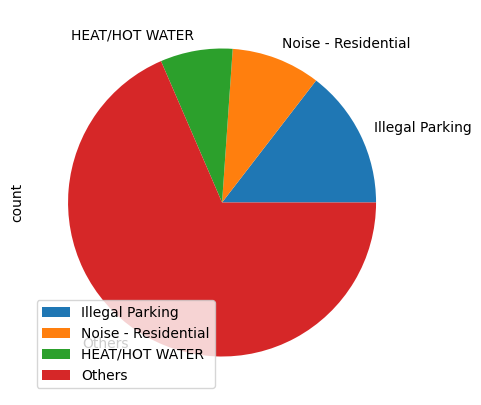

In [44]:
%matplotlib inline

some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)